# Current Amplifier Output Calibration

This script converts current_output_cal_functions into the OutputChannel() class for easier re-use (to cal Channel U and Channel V). Hopefully this serves as a starting point for my calibration routines, making them easier to convert to python-tcal

In [1]:
import serial
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import pyvisa as visa
import struct
from pathlib import Path
from scipy.interpolate import interp1d

from save_cal_data import save_measurement, load_measurement
from progressbar import update_progress
from user_prompts import *

In [2]:
def serialQry(port, command):
    port.reset_input_buffer()
    port.write((command + '\n').encode('ascii'))
    return port.readline().decode('ascii').strip() #strip removes white space

def serialCmd(port, command):
    port.reset_input_buffer()
    port.write((command + '\n').encode('ascii'))

In [3]:
def rms(x):
    return np.sqrt(np.mean(x**2))

In [4]:
sr542 = serial.Serial(port='COM11', baudrate=115200, timeout=.5)
sr542.set_buffer_size(24570)
cs580 = serial.Serial(port='COM10', baudrate=9600, timeout=0.5)
rm = visa.ResourceManager()
rm.list_resources()
dvm = rm.open_resource('USB0::0x0957::0xB318::MY52449038::INSTR')

In [5]:
print(serialQry(sr542, '*IDN?'))
print(serialQry(cs580, '*IDN?'))
print(dvm.query('*IDN?'))

Stanford_Research_Systems, SR542, s/n00001007, v0.10
Stanford_Research_Systems,CS580,s/n137132,ver1.14
Agilent Technologies,34450A,MY52449038,00.56-00.63



In [6]:
sr542.get_settings()

{'baudrate': 115200,
 'bytesize': 8,
 'parity': 'N',
 'stopbits': 1,
 'xonxoff': False,
 'dsrdtr': False,
 'rtscts': False,
 'timeout': 0.5,
 'write_timeout': None,
 'inter_byte_timeout': None}

# Define Cal Functions

In [10]:
class Resistor():
    def __init__(self, Rnom, tol):
        self.R = Rnom
        self.Rnom = Rnom
        self.tol = tol
        
    def SweepIMeasV(self, I_init, I_final, I_step):        
        I_sweep = np.arange(I_init, I_final + I_step, I_step)

        serialCmd(cs580, 'GAIN G50mA')
        serialCmd(cs580, f'CURR {I_init:.3f}')
        serialCmd(cs580, 'INPT OFF')
        serialCmd(cs580, 'SOUT ON')

        time.sleep(1.0)
        V_meas = []

        for curr in I_sweep:
            serialCmd(cs580, f'CURR {curr:.3f}')
            time.sleep(1.0)
            V_meas.append(float(dvm.query('MEAS:VOLT:DC? 0.1, 3e-5').strip('\n')))
            
            update_progress(len(V_meas) / len(I_sweep))

        serialCmd(cs580, 'CURR 0')
        serialCmd(cs580, 'SOUT OFF')

        coeffs, cov = np.polyfit(I_sweep, V_meas, 1, cov=True)
        fit = np.poly1d(coeffs)
        R_meas = coeffs[0]
        R_std = np.sqrt(np.diag(cov))[0]
        print(f'R = {R_meas:.5e} +- {R_std:.5e} Ohms')
        
        fig, ax = plt.subplots()
        
        ax.plot(I_sweep, V_meas, '.')
        ax.plot(I_sweep, fit(I_sweep), label=f'fit: R={coeffs[0]:.6} Ohms')
        ax.set_xlabel('applied current (A)')
        ax.set_ylabel('meas voltage (V)')
        ax.legend()   
        ax.set_title('4 pt I-V Resistance Measurement')
        
        # define reasonable measurement bounds: +/- tol%
        if (R_meas > self.Rnom*(1 + self.tol/100)) or (R_meas < self.Rnom*(1 - self.tol/100)):
            print('Resistance measurement out-of-spec')
            return
        else:
            self.R = R_meas

class OutputChannel(Resistor):
    def __init__(self, channel, Rnom=0.1, tol=10):
        super().__init__(Rnom, tol)
        if channel == 'U' or channel == 'V':
            self.channel = channel
        else:
            raise ValueError('Invalid channel assignment')
        
        # Default all values to ideal or nominal        
        self.Vref = 3.3 # volts
        self.dacBits = 12
        self.numCodes = 2**self.dacBits
        self.R_f = 10e3 # ohms
        self.R_in = 90.9e3 # ohms        
        self.HowlandGain = self.R_f/(self.R_in*self.Rnom)
        self.LSB_A = self.Vref/self.numCodes*self.HowlandGain # LSB size, in Amps
        self.on_unit_lut = self.DownloadCalData()
        self.cal_lut = np.arange(0, self.numCodes, 1) # the calculated correction LUT
        self.idealCurrent = np.poly1d([self.Vref/self.numCodes, -self.Vref/2])*self.HowlandGain # linear current output defined by [slope, offset]
        self.allCodes = np.arange(0, self.numCodes, 1)
        self.txFun = self.idealCurrent(self.allCodes) # The Measured Transfer Function: txFun[code] = output (A)
        self.cald = False
        self.passed = False
        
    def CurrentToLsb(self, I_A):
        return I_A/self.LSB_A

    def LsbToCurrent(self, bits):
        return bits*self.LSB_A

    def MeasVoltageVsDacCode(self, codes):
        serialCmd(sr542, '$CEN ON')
        #time.sleep(30.0) # TODO: do I still need this?

        t0 = time.time()

        V_sense = []
        for dacCode in codes:
            if(self.channel=='U'):
                serialCmd(sr542, f'$SUV {dacCode}, 2048')
            elif(self.channel=='V'):
                serialCmd(sr542, f'$SUV 2048, {dacCode}')
            else:
                print('Invalid Channel')
                break

            time.sleep(0.1) #TODO: how long to sleep here?
            V = float(dvm.query('MEAS:VOLT:DC? 10, 1.5e-6')) #voltage measured across ~R_sense
            #print(f'{dacCode}, {V}')
            V_sense.append(V) 

            update_progress(len(V_sense) / len(codes))
            
        # Zero the output and turn the Current Source off
        serialCmd(sr542, '$SUV 2048, 2048')
        serialCmd(sr542, '$CEN OFF')

        print(f'elapsed time = {time.time() - t0}')

        return np.array(V_sense)
    
    def MeasuredVoltageToCurrentError(self, codes, V_meas):
        I_A_meas = V_meas/self.R 
        I_A_error = I_A_meas - self.idealCurrent(codes)
        I_c_error = I_A_error/self.LSB_A
        
        return I_c_error

    def PlotCurrentError(self, codes, V_meas):    
        I_c_error = self.MeasuredVoltageToCurrentError(codes, V_meas)

        minor_ticks = np.arange(int(min(I_c_error)), int(max(I_c_error)) + 1, 1)

        fig, axL = plt.subplots(figsize=(8,8))
        axL.plot(codes, I_c_error, '.', label='measured error')
        if not np.array_equal(self.cal_lut, np.arange(0, 4096, 1)):
            axL.plot(self.allCodes, (self.txFun[self.cal_lut[self.allCodes]] - self.idealCurrent(self.allCodes))/self.LSB_A, 
                     label='expected error')        
        axL.set_xlabel('dac code')
        axL.set_ylabel('output error (LSBs)')    
        axL.set_yticks(minor_ticks, minor=True)
        axL.grid('y')
        axL.grid('y', which='minor', alpha=0.5)
        axL.set_title(f'Channel {self.channel} Output Error')
        axL.legend()

        axR = axL.secondary_yaxis('right', functions=(self.LsbToCurrent, self.CurrentToLsb))
        axR.grid(axis='y')
        axR.set_ylabel('output error (A)')
        
    def PlotComparison(self, codes, V_meas, labels):
        # Expects a list of codes and a list of measurements to be able to compare multiple measurements

        numOfCodeSweeps = len(codes)
        numOfMeasurementSweeps = len(V_meas)

        if numOfCodeSweeps != numOfMeasurementSweeps:
            print('Improper number of measurements') 
            return

        fig, axL = plt.subplots(figsize=(8,8))
        for i in range(numOfCodeSweeps):            
            I_c_error = self.MeasuredVoltageToCurrentError(codes[i], V_meas[i])
            axL.plot(codes[i], I_c_error, label=labels[i])
            
        axL.set_xlabel('dac code')
        axL.set_ylabel('output error (LSBs)')
        axL.grid('y')
        axL.legend()
        axL.set_title(f'Channel {self.channel} Output Error Comparison')
        
        axR = axL.secondary_yaxis('right', functions=(self.LsbToCurrent, self.CurrentToLsb))        
        axR.set_ylabel('output error (A)')
        
    def ApplyLutLimits(self, lut):
        return np.rint(np.clip(lut, 0, self.numCodes-1)).astype(np.int16)
        
    def CreateLUT(self, codes, V_meas):
        V_meas_interp = interp1d(codes, V_meas, kind='cubic')
        I_c_error = self.MeasuredVoltageToCurrentError(self.allCodes, V_meas_interp(self.allCodes))                       

        #self.cal_lut = np.rint(np.clip(self.allCodes - I_c_error, 0, 4095)).astype(np.int16)        
        self.cal_lut = self.ApplyLutLimits(self.allCodes - I_c_error)
        # I think this is the better way to create the transfer function, since it relies on measured values
        self.txFun = V_meas_interp(self.allCodes)/self.R        
    
    def PolyFitLUT(self, codes, V_meas, order):
        I_c_error = self.MeasuredVoltageToCurrentError(codes, V_meas)
        # Ignore dac codes within 5% of limits
        fitRange = np.where((codes > 0.05*4095) & (codes < 0.95*4095))
        coeffs, cov = np.polyfit(codes[fitRange], I_c_error[fitRange], order, cov=True)
        fit = np.poly1d(coeffs)

        fig, ax = plt.subplots(figsize=(8,8))
        ax.plot(codes, I_c_error, '.-')
        ax.plot(self.allCodes, fit(self.allCodes))
        ax.set_xlabel('dac code')
        ax.set_ylabel('output error (LSBs)')
        ax.grid('y')
        axR = ax.secondary_yaxis('right', functions=(self.LsbToCurrent, self.CurrentToLsb))        
        axR.set_ylabel('output error (A)')

        #lut = np.rint(np.clip(self.allCodes - fit(self.allCodes), 0, 4095)).astype(np.int16)
        self.cal_lut = self.ApplyLutLimits(self.allCodes - fit(self.allCodes))
        # To create the txFun from the polyfit, note that:
        # error_A = actual_A - ideal_A, therefore:
        # actual_A = ideal_A + error_A.
        # Note: Since error_A in this case is based on a fit that ignores data near dacCode limits,
        # this transfer function won't be accurate near those limits
        self.txFun = np.polyadd(self.idealCurrent, fit*self.LSB_A)(self.allCodes)         

    def ApplyLUTCorrection(self):
        fig, ax = plt.subplots(figsize=(8,8))
        
        ax.plot(self.allCodes, (self.txFun[self.allCodes] - self.idealCurrent(self.allCodes))/self.LSB_A, '.', label='uncal')
        ax.plot(self.allCodes, (self.txFun[self.cal_lut[self.allCodes]] - self.idealCurrent(self.allCodes))/self.LSB_A, label='LUT correction')        
        ax.grid(axis='y')
        ax.set_xlabel('dac code')
        ax.set_ylabel('output error (LSBs)')
        ax.legend()
        ax.set_title('Expected Calibrated Output Error')
        
    def EvaluatePassFail(self, dacCodes, V_meas):
        error_A = V_meas/self.R - self.idealCurrent(dacCodes)
        
        rms_error_LSB = rms(error_A/self.LSB_A)       
            
        print(f'rms error = {rms(error_A/self.LSB_A):.3f} LSBs')
        
        if rms_error_LSB < 3: # TODO: what to set this to?
            self.passed = True
            print('This measurement passed verification!')
        else:
            self.passed = False
            print('This measurement failed verification')
            
        return self.passed
            
    def UploadCalData(self, lut = None):
        if lut is None:
            lut = self.cal_lut
        t0 = time.time()        
        serialCmd(sr542, f'$DAA CH{self.channel}')
        # This causes the firmware to entire a blocking state where
        # it expects *exactly* 4096 words (8192 bytes)
        for i in range(4096):
            bytesToWrite = struct.pack('<h', lut[i])  # format as little-endian short          
            sr542.write(bytesToWrite)            
    
        print(f'Total elapsed time = {time.time() - t0} seconds')
        
    def WriteCalDataToNvm(self):
        serialCmd(sr542, f'$DCN CH{self.channel}')
        
    def ResetCal(self):
        self.UploadCalData(lut = np.arange(0, 4096, 1))
        self.cald = False
        
    def DownloadCalData(self):
        # need to make sure sr542 buffer size is big enough to handle this
        
        serialCmd(sr542, f'$DAA? CH{self.channel}')
        # wait for all data to download
        time.sleep(4.0)
        
        lut = []
        for line in sr542.readlines():
            lut.append(int(line.decode('ascii').strip()))
            
        # The array is all zeros    
        if(np.count_nonzero(lut==0) == len(lut)):            
            self.cald = False
            print('This channel has not yet been calibrated (all zeros)')          
        # Check if the LUT is the default (where code = index)
        elif(np.array_equal(lut, np.arange(0, 4096, 1))):            
            self.cald = False
            print('This channel has not yet been calibrated (code = index)')
        else:
            self.cald = True
            print('This channel has an existing non-trivial saved calibration')
            
        return np.array(lut)
            
    def CompareLUTs(self, lut1 = None, lut2 = None):
        if lut1 is None:
            compareToPrevCal = True
            lut1 = self.on_unit_lut
        else:
            compareToPrevCal = False
            
        if lut2 is None:
            lut2 = self.cal_lut
        
        diff = lut1 - lut2
        
        fig, ax = plt.subplots()
        
        ax.plot(diff, 'o-')
        ax.set_xlabel('index')
        ax.set_ylabel('LUT difference (dac code)')
        
        # TODO: write this so that it reports whether the comparison is to an existing cal
        # or the default (uncal) lut
        if np.array_equal(lut1, np.arange(0, 4096, 1)):
            print(f'The average difference between the default (uncal) LUT and the new cal is {np.mean(diff):.2f} codes')
        elif compareToPrevCal:
            print(f'The average difference between the prev cal and the new cal is {np.mean(diff):.2f} codes')        
        else:
            print(f'The average difference between these two LUTs is {np.mean(diff):.2f} codes')
            
    def SaveCalData(self):
        controllerSn = serialQry(sr542, '*IDN?').split(',')[2].strip(' s/n')
        save_measurement('.\CalData', controllerSn, f'Ch{self.channel}_outputCal', self.cal_lut, ['dac code'], fmt='%d')

    def LoadCalData(self):
        controller_sn = serialQry(sr542, '*IDN?').split(',')[2].strip(' s/n')
        data = load_measurement('.\CalData', controller_sn, f'Ch{self.channel}_outputCal')

        if not data.any():
            print('No measurements have been saved for this sn')
        else:
            self.cal_lut = data            
        
    def Calibrate(self):        
        self.ResetCal()
        self.SweepIMeasV(-90e-3, 90e-3, 10e-3)
        testCodes = np.linspace(0, self.numCodes-1, 100, dtype=int)
        V_uncald = self.MeasVoltageVsDacCode(testCodes)
        if self.EvaluatePassFail(testCodes, V_uncald):
            proceed = yes_or_no("Measurement passed. Continue with cal anyway?")
        else:
            proceed = True        

        if proceed:
            self.CreateLUT(testCodes, V_uncald)
            # OR
            self.PolyFitLUT(testCodes, V_uncald, 4)
            self.CompareLUTs()
            if yes_or_no("Proceed with LUT upload to SR542?"):
                self.UploadCalData()
                verifyCodes = np.linspace(3, self.numCodes-1, 200, dtype=int)
                V_cald = self.MeasVoltageVsDacCode(verifyCodes)
                self.PlotComparison([testCodes, verifyCodes], [V_uncald, V_cald], ['uncal', 'cal'])
                if self.EvaluatePassFail(verifyCodes, V_cald) and yes_or_no("Save to NVM?"):
                    self.WriteCalDataToNvm()
                    self.SaveCalData()
        

Progress: [####################] 100.0%
R = 9.92225e-02 +- 1.56608e-05 Ohms


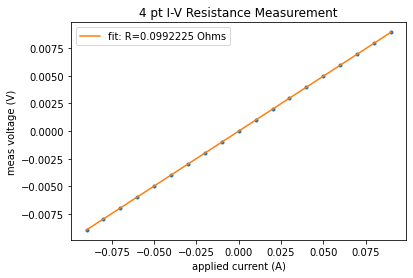

In [52]:
R_U = Resistor(0.1, 10)
R_U.SweepIMeasV(-90e-3, 90e-3, 10e-3)

Progress: [####################] 100.0%
R = 9.92400e-02 +- 2.07306e-05 Ohms


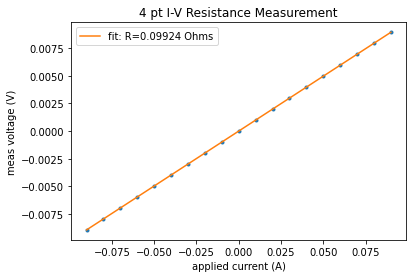

In [8]:
R_V = Resistor(0.1, 10)
R_V.SweepIMeasV(-90e-3, 90e-3, 10e-3)

## Check the status of the onboard cal for both channels


In [11]:
chv = OutputChannel('V')

This channel has an existing non-trivial saved calibration


In [12]:
chv.LoadCalData()

Loading .\CalData\ChV_outputCal\00001007_ChV_outputCal_11.csv


In [14]:
import pandas as pd

In [22]:
df = pd.DataFrame(np.array(chv.cal_lut, dtype=int), columns=['dacChanU.dacCodes'])
df['commanded_code'] = df.index
df['nominal current (A)'] = df.index/4095*1.65*1.1

In [23]:
df.loc[2000:2100]

,dacChanU.dacCodes,commanded_code,nominal current (A)
2000,1993,2000,0.886447
2001,1994,2001,0.886890
2002,1995,2002,0.887333
2003,1996,2003,0.887777
2004,1997,2004,0.888220
...,...,...,...
2096,2090,2096,0.928996
2097,2091,2097,0.929440
2098,2092,2098,0.929883
2099,2093,2099,0.930326


In [10]:
chu = OutputChannel('U')

Progress: [####################] 100.0%
R = 9.93076e-02 +- 2.01621e-05 Ohms


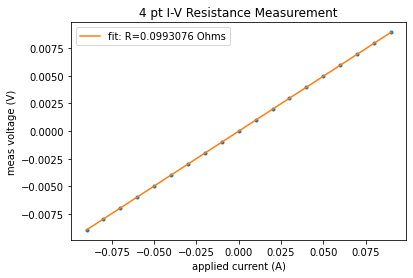

In [11]:
chv.SweepIMeasV(-90e-3, 90e-3, 10e-3)

### Check if the channel has already been cal'd

In [12]:
chv.DownloadCalData()

This channel has not yet been calibrated (code = index)


array([   0,    1,    2, ..., 4093, 4094, 4095])

### Determine if you want to reset the cal or not

In [13]:
chv.ResetCal()

Total elapsed time = 0.7036213874816895 seconds


In [14]:
# And verify that it's been reset
chv.DownloadCalData()

This channel has not yet been calibrated (code = index)


array([   0,    1,    2, ..., 4093, 4094, 4095])

In [13]:
testCodes = np.linspace(0, chv.numCodes-1, 100, dtype=int)
V_V = chv.MeasVoltageVsDacCode(testCodes)
chv.PlotCurrentError(testCodes, V_V)

Progress: [####################] 100.0%
elapsed time = 122.6876311302185


TypeError: PolyFitLUT() missing 1 required positional argument: 'order'

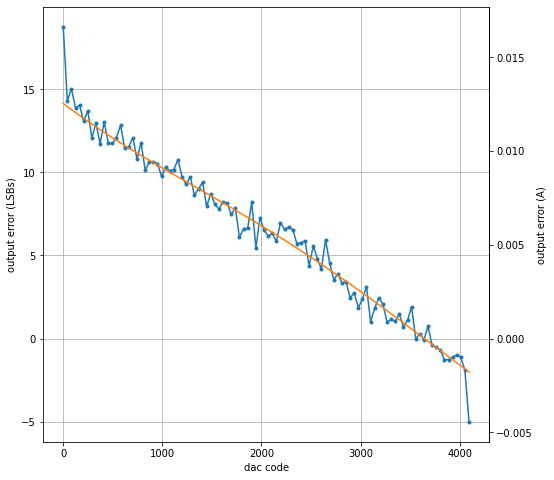

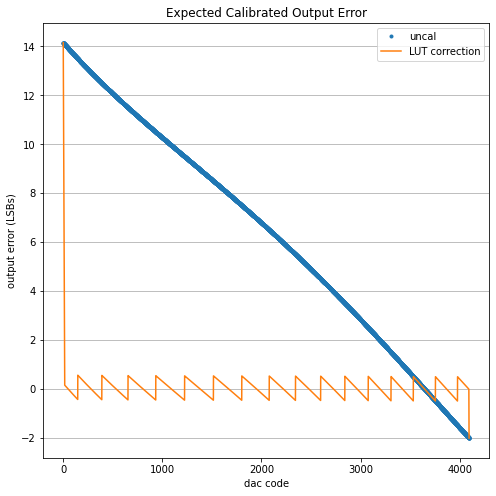

In [14]:
#chv.CreateLUT(testCodes, V_V)
chv.PolyFitLUT(testCodes, V_V, 4)
chv.ApplyLUTCorrection()

In [15]:
chv.EvaluatePassFail(testCodes, V_V)

rms error = 8.006 LSBs
This measurement failed verification


False

### Extract the full-scale current output of this channel

In [16]:
# Full-scale current, in Amps
(max(chv.txFun) - min(chv.txFun))/2

1.8075742050049581

In [17]:
chv.HowlandGain*chv.Vref/2

1.8151815181518152

## OPTIONAL: Experimental Verification of the Calibration

Before actually uploading the 4096-element LUT to the controller, can simulate a calibrated DAC by commanding codes that have been corrected by the LUT. This step is not so necessary now that uploads can be performed much more quickly with the $DAA command

In [19]:
verifyCodes = np.arange(3, chv.numCodes-1, 40, dtype=int)
V_V_corrected = chv.MeasVoltageVsDacCode(chv.cal_lut[verifyCodes])
chv.PlotCurrentError(verifyCodes, V_V_corrected)

Progress: [####################] 100.0%
elapsed time = 126.21897506713867


In [20]:
chv.EvaluatePassFail(verifyCodes, V_V_corrected)

rms error = 1.618 LSBs
This measurement passed verification!


True

## Upload LUTs to SR542

The average difference between the prev cal and the new cal is 6.32 codes


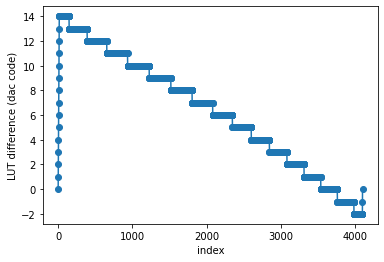

In [21]:
chv.CompareLUTs()

In [22]:
chv.UploadCalData()

Total elapsed time = 0.7048115730285645 seconds


## Verify the Uploaded LUT

In [24]:
# Define the measurement sweep
verifyCodes = np.linspace(3, chv.numCodes-1, 200, dtype=int)
V_V_cal = chv.MeasVoltageVsDacCode(verifyCodes)

Progress: [####################] 100.0%
elapsed time = 245.0234603881836


In [25]:
# The original test codes and uncal'd measurement
chv.EvaluatePassFail(testCodes, V_V)

rms error = 8.006 LSBs
This measurement failed verification


False

In [26]:
# The verification codes, and cal'd measurement
chv.EvaluatePassFail(verifyCodes, V_V_cal)

rms error = 1.692 LSBs
This measurement passed verification!


True

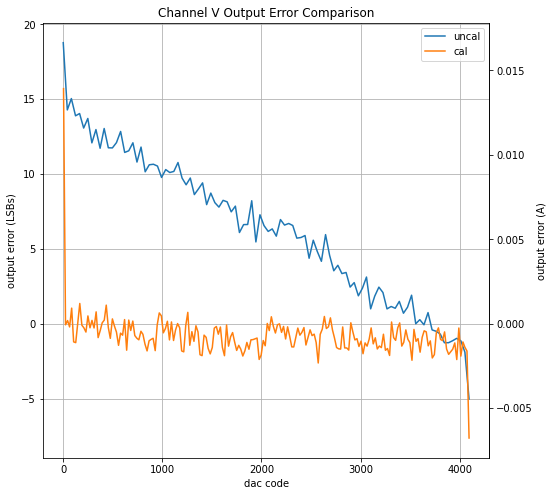

In [27]:
chv.PlotComparison([testCodes, verifyCodes], [V_V, V_V_cal], ['uncal', 'cal'])

### And if everything looks good, save the cal table to NVM:

In [28]:
chv.WriteCalDataToNvm()
chv.SaveCalData()

# Channel U Calibration

In [59]:
chu = OutputChannel('U', 0.1, 10)
chu.DownloadCalData()

This channel has an existing non-trivial saved calibration


array([   0,    0,    0, ..., 4091, 4092, 4093])

In [30]:
# If you want to perform a fresh-cal, need to reset the existing cal table in the controller's RAM
chu.ResetCal()

Total elapsed time = 0.7052345275878906 seconds


Progress: [####################] 100.0%
elapsed time = 126.16406273841858
rms error = 1.619 LSBs
Calibration Passed!
Total elapsed time = 0.7045607566833496 seconds


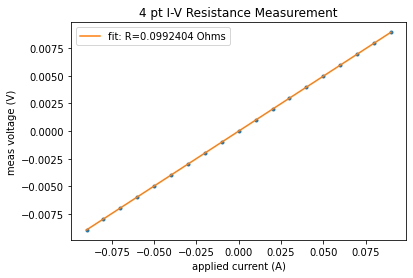

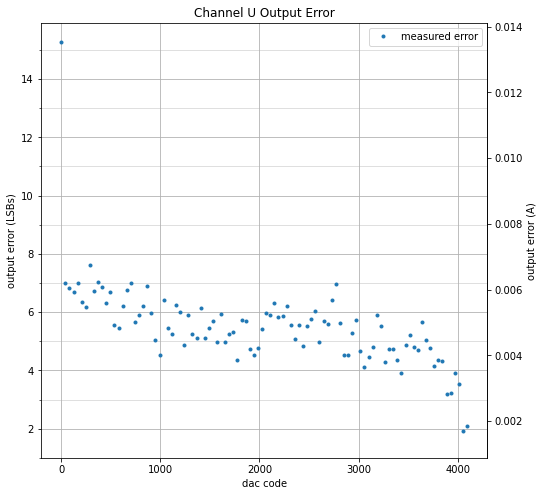

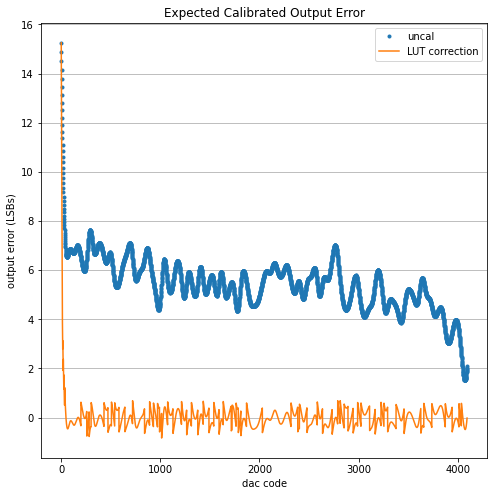

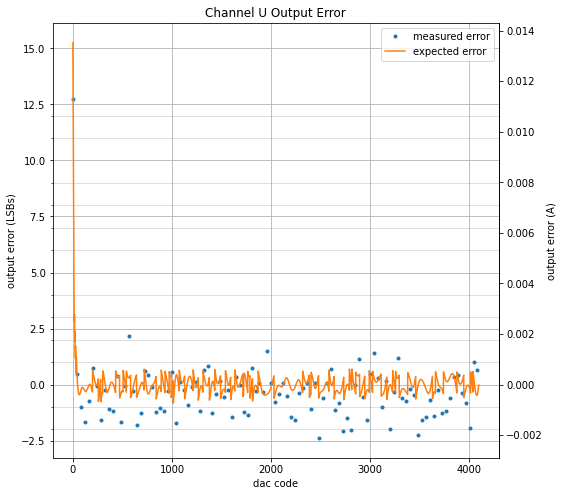

In [33]:
chu.SweepIMeasV(-90e-3, 90e-3, 10e-3)

testCodes = np.linspace(0, chu.numCodes-1, 100, dtype=int)
V_U = chu.MeasVoltageVsDacCode(testCodes)
chu.PlotCurrentError(testCodes, V_U)

chu.CreateLUT(testCodes, V_U)
chu.ApplyLUTCorrection()

verifyCodes = np.arange(3, chu.numCodes-1, 40, dtype=int)
V_U_corrected = chu.MeasVoltageVsDacCode(chu.LUT[verifyCodes])
chu.PlotCurrentError(verifyCodes, V_U_corrected)

if chu.EvaluatePassFail(verifyCodes, V_U_corrected):    
    chu.UploadCalData()

## Verify the uploaded LUTs

In [35]:
chu.DownloadCalData()

This channel has an existing non-trivial saved calibration


array([   0,    0,    0, ..., 4091, 4092, 4093])

In [36]:
# Define the measurement sweepa
verifyCodes = np.linspace(3, chu.numCodes-1, 200, dtype=int)

V_U_cal = chu.MeasVoltageVsDacCode(verifyCodes)

Progress: [####################] 100.0%
elapsed time = 244.95599246025085


In [37]:
# Before cal
chu.EvaluatePassFail(testCodes, V_U)

rms error = 5.671 LSBs
Calibration Failed


False

In [38]:
# After cal
chu.EvaluatePassFail(verifyCodes, V_U_cal)

rms error = 1.338 LSBs
Calibration Passed!


True

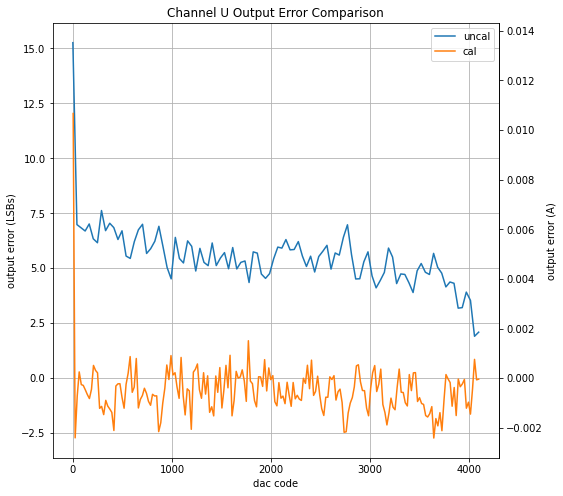

In [39]:
chu.PlotComparison([testCodes, verifyCodes], [V_U, V_U_cal], ['uncal', 'cal'])

### And if everything looks good, save the cal table to NVM:

In [40]:
chu.WriteCalDataToNvm()
chu.SaveCalData()

# Try to run the full Cal Routine

In [129]:
chu = OutputChannel('U')

This channel has not yet been calibrated (code = index)


Progress: [####################] 100.0%
elapsed time = 122.50759768486023
rms error = 5.608 LSBs
This measurement failed verification


False

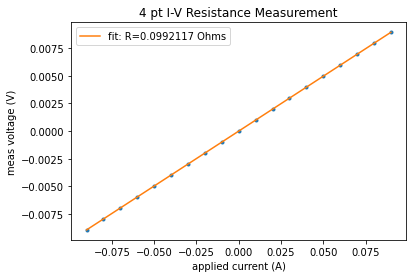

In [130]:
chu.ResetCal()
chu.SweepIMeasV(-90e-3, 90e-3, 10e-3)
testCodes = np.linspace(0, chu.numCodes-1, 100, dtype=int)
V_uncald = chu.MeasVoltageVsDacCode(testCodes)
chu.EvaluatePassFail(testCodes, V_uncald)    

The average difference between these two LUTs is 5.37 codes


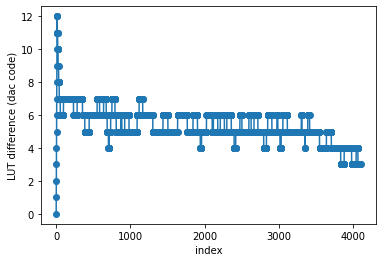

In [147]:
chu.CreateLUT(testCodes, V_uncald)
chu.CompareLUTs(lut1 = np.arange(0, 4096, 1))

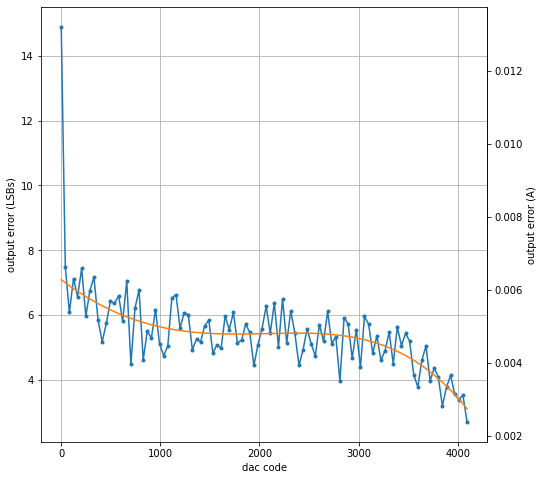

In [137]:
polyLut = chu.PolyFitLUT(testCodes, V_uncald, 4)

In [29]:
chu.DownloadCalData()

This channel has an existing non-trivial saved calibration


array([   0,    0,    0, ..., 4089, 4090, 4091])

Progress: [####################] 100.0%
elapsed time = 245.00428295135498
rms error = 1.208 LSBs
This measurement passed verification!
Save to NVM? (y/n):y


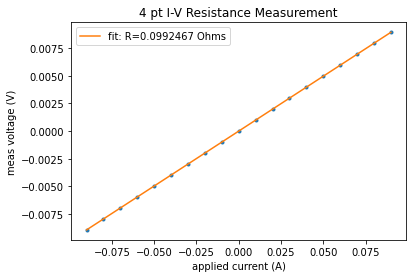

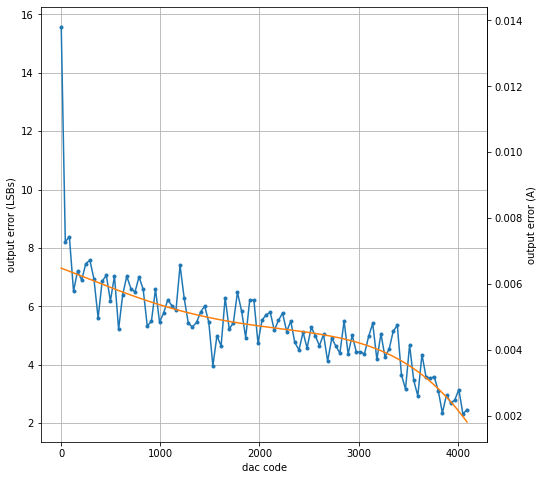

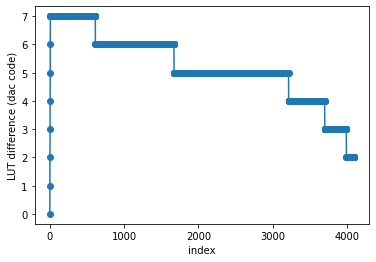

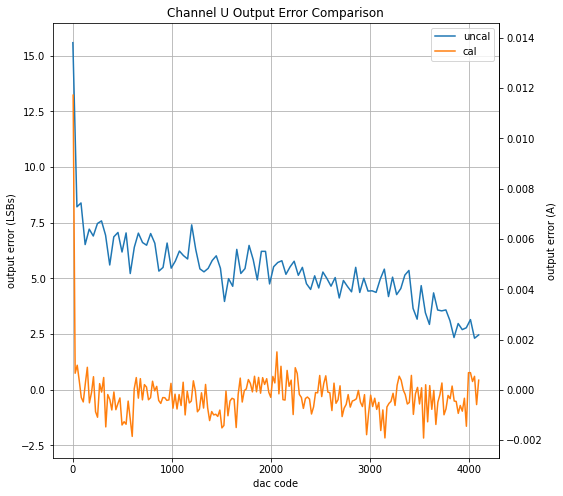

In [164]:
chu = OutputChannel('U')
chu.Calibrate()

Progress: [####################] 100.0%
elapsed time = 122.56409692764282
rms error = 7.179 LSBs
This measurement failed verification
The average difference between the prev cal and the new cal is 0.16 codes
Proceed with LUT upload to SR542? (y/n):n


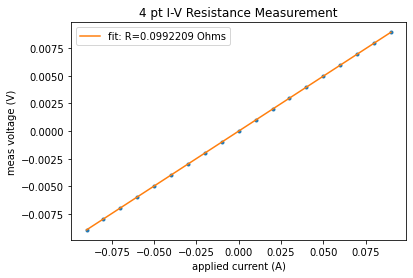

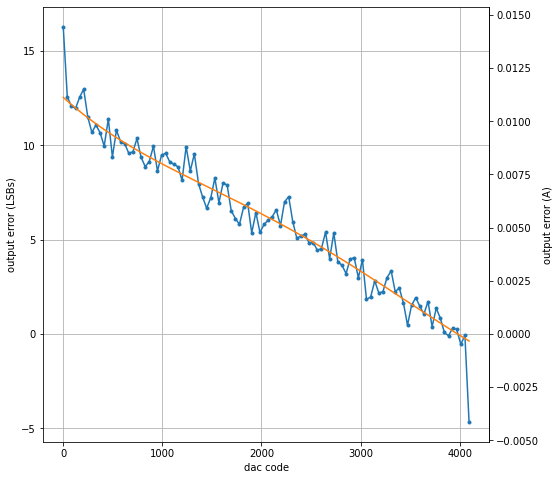

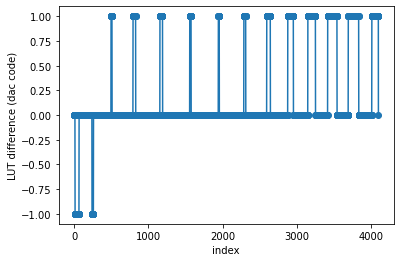

In [170]:
chv = OutputChannel('V')
chv.Calibrate()

# Reproducibility Tests

In [29]:
chv.R

0.09930763297157905

In [83]:
testCodes = np.linspace(0, chv.numCodes-1, 100, dtype=int)

numTrials = 6

V = []
for i in range(numTrials):
    V.append(chv.MeasVoltageVsDacCode(testCodes))    
    
V_avg = np.mean(V, axis=0)
V.append(V_avg)

chv.PlotComparison([testCodes, testCodes, testCodes, testCodes], V, ['trial1', 'trial2', 'trial3', 'avg'])

Progress: [####################] 100.0%
elapsed time = 122.56045484542847
Improper number of measurements


In [72]:
def MeasVoltageToCurrentError(codes, V_meas, R, idealCurrent, LSB_A):
    I_A = V_meas/R
    I_A_error = I_A - idealCurrent(codes)
    I_c_error = I_A_error/LSB_A
    
    return I_c_error

In [84]:
I_c = MeasVoltageToCurrentError(testCodes, V, chv.R, chv.idealCurrent, chv.LSB_A)
I_c

array([[ 1.68947275e+01,  1.12538700e+01,  1.25429870e+01,
         1.20722101e+01,  1.25600681e+01,  1.18308313e+01,
         1.03046901e+01,  1.06390066e+01,  1.08606123e+01,
         1.13741727e+01,  1.09667133e+01,  1.09760663e+01,
         1.07475226e+01,  9.91463965e+00,  9.84864360e+00,
         9.73883858e+00,  1.00920919e+01,  9.77451528e+00,
         8.93070247e+00,  9.27166106e+00,  9.16358327e+00,
         8.99649023e+00,  1.00129694e+01,  9.77499597e+00,
         8.84632932e+00,  9.38996452e+00,  9.54528352e+00,
         7.82574755e+00,  9.79622876e+00,  9.22802400e+00,
         8.75742044e+00,  9.26165690e+00,  8.67449262e+00,
         7.95226491e+00,  7.76516144e+00,  7.72531332e+00,
         8.76046658e+00,  7.33386156e+00,  7.04706191e+00,
         7.99102746e+00,  7.37128282e+00,  6.68539024e+00,
         7.27484790e+00,  6.64450549e+00,  5.95208757e+00,
         6.51063147e+00,  6.19076467e+00,  7.51969427e+00,
         6.52163120e+00,  5.96531488e+00,  6.56342625e+0

In [88]:
len(I_c)

7

In [90]:
fig, axL = plt.subplots(figsize=(8,8))

axL.plot(testCodes, I_c[0], alpha=0.5, label='trial1')
axL.plot(testCodes, I_c[1], alpha=0.5, label='trial2')
axL.plot(testCodes, I_c[2], alpha=0.5, label='trial3')
axL.plot(testCodes, I_c[3], alpha=0.5, label='trial4')
axL.plot(testCodes, I_c[4], alpha=0.5, label='trial5')
axL.plot(testCodes, I_c[5], alpha=0.5, label='trial6')
axL.plot(testCodes, I_c[6], color='black', alpha=1.0, label='avg')

axL.set_xlabel('dac code')
axL.set_ylabel('output error (LSBs)')
axL.grid('y')
axL.legend()
axL.set_title(f'Channel V Output Error Comparison')

axR = axL.secondary_yaxis('right', functions=(chv.LsbToCurrent, chv.CurrentToLsb))        
axR.set_ylabel('output error (A)')

Text(0, 0.5, 'output error (A)')

In [92]:
len(V[0:-1])

6

In [97]:
np.mean(np.std(I_c[0:-1], axis=0))

0.643548292479235

## Check sweep-direction dependence

Progress: [####################] 100.0%
elapsed time = 122.44384980201721


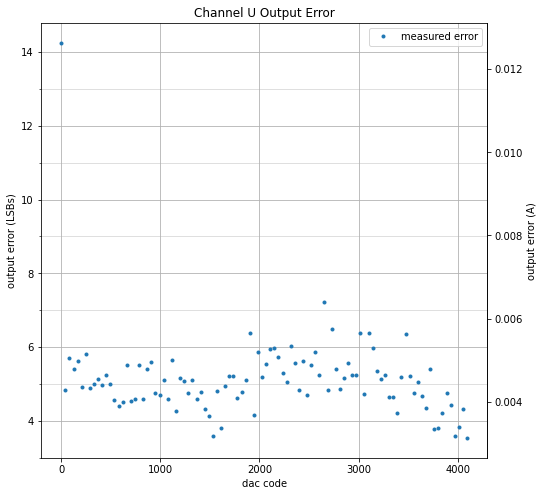

In [29]:
testCodes = np.linspace(0, chu.numCodes-1, 100, dtype=int)
V_U_upSweep = chu.MeasVoltageVsDacCode(testCodes)
chu.PlotCurrentError(testCodes, V_U_upSweep)

In [30]:
V_U_dnSweep = chu.MeasVoltageVsDacCode(np.flip(testCodes))
chu.PlotCurrentError(testCodes, np.flip(V_U_dnSweep))

Progress: [####################] 100.0%
elapsed time = 122.50920629501343


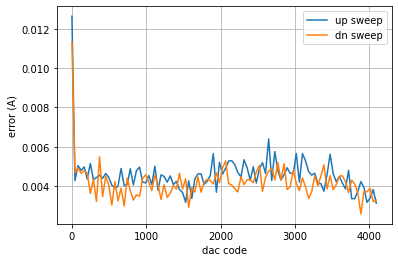

In [31]:
plt.plot(testCodes, V_U_upSweep/chu.R - chu.idealCurrent(testCodes), label='up sweep')
plt.plot(testCodes, np.flip(V_U_dnSweep)/chu.R - chu.idealCurrent(testCodes), label='dn sweep')
plt.legend()
plt.xlabel('dac code')
plt.ylabel('error (A)')
plt.grid()

In [43]:
serialQry(sr542, 'LERR?')

'106'